Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Notebook overview

This notebook provides an interactive demonstration of adaptive dynamics prediction for rigid-body dynamics with data output from a PyBullet simulation of thrown objects. It describes the general structure of an adaptive predictor, mathematically constructs an adaptive predictor for rigid-body dynamics, and then provides an implementation.

In [ ]:
!pip install pybullet
!pip install bullet

In [ ]:
import pybullet as p
import bullet as b
import pybullet_data
import numpy as onp
import jax
from jax import numpy as jnp
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
import functools

from jax.config import config
config.update('jax_enable_x64', True)

### Imported Code

In [ ]:
""" Quaternion functions """

@jax.jit
def skew(w):
  w = jnp.reshape(w, (3))
  return jnp.array([[0.0, -w[2], w[1]],\
                   [w[2], 0.0, -w[0]],\
                   [-w[1], w[0], 0.0]])

@jax.jit
def to_axis_angle(q):
  angle = 2.0 * jnp.arccos(q[0])
  axis = jnp.where(angle, q[1:] / jnp.sin(angle / 2.0), 0.0)
  return (axis, angle)


@jax.jit
def normalize(q):
  return q / jnp.linalg.norm(q)


@jax.jit
def multiply(q, p):
  return jnp.concatenate((jnp.array([q[0] * p[0] - p[1:] @ q[1:]]),
                         q[0] * p[1:] + p[0] * q[1:] + jnp.cross(q[1:], p[1:])))


@jax.jit
def vector_multiply(v, q):
  """Multiplication between quaternions [0, v0, v1, v2] and q."""
  return multiply(jnp.concatenate((jnp.array([0.0]), v)), q)


@jax.jit
def to_rotation_matrix(q):
  (omega, theta) = to_axis_angle(q)
  omega_sk = skew(omega)
  return jnp.eye(3) + jnp.sin(theta) * omega_sk + (
      1.0 - jnp.cos(theta)) * omega_sk @ omega_sk

In [ ]:
""" Potential functions for mirror descent """

@jax.jit
def p_norm(x, p):
  return .5*jnp.linalg.norm(x, p)**2


@jax.jit
def grad_p(x, p):
  """Direct calculation of the gradient of p_norm(x, p)."""
  return jnp.linalg.norm(x, p)**(2-p)*jnp.abs(x)**(p-1)*jnp.sign(x)


@jax.jit
def inv_grad_p(x, p):
  """See https://arxiv.org/pdf/1912.13154.pdf, Section 8.1."""
  q = 1/(1 - 1/p)  # 1/q + 1/p == 1
  return grad_p(x, q)


@jax.jit
def hypentropy(x, beta):
  """See https://arxiv.org/pdf/1902.01903.pdf."""
  return jnp.sum(x*jnp.arcsinh(x/beta) - jnp.sqrt(x**2 + beta**2))


@jax.jit
def grad_hyp(x, beta):
  """See https://arxiv.org/pdf/1902.01903.pdf."""
  return jnp.arcsinh(x/beta)


@jax.jit
def inv_grad_hyp(x, beta):
  """See https://arxiv.org/pdf/1902.01903.pdf."""
  return beta*jnp.sinh(x)

In [ ]:
"""Class for adaptive dynamics prediction."""

from typing import Callable, Dict, Tuple

@functools.partial(jax.jit, static_argnums=(0, 1))
def rollout_prediction(norm_state: Callable[[jnp.ndarray], jnp.ndarray],
                       predict_state: Callable[[jnp.ndarray, jnp.ndarray, int],
                                               jnp.ndarray],
                       params: jnp.ndarray, init_state: jnp.ndarray,
                       t_range: jnp.ndarray) -> jnp.ndarray:
  """Given a measurement, update the parameters and rollout the prediction.

  Args:
    norm_state: A function used to normalize the state after each step.
    predict_state: A function mapping the current state estimate to the state
    params: Current adaptive parameter estimates.
    estimate at the next timestep.
    init_state: Initial state for this rollout.
    t_range: Range of discrete-time indices for the rollout.

  Returns:
    traj: The predicted state trajectory.
  """
  def scan_fn(xhatt: jnp.ndarray, t: int) -> Tuple[jnp.ndarray, jnp.ndarray]:
    xhattp1 = norm_state(predict_state(xhatt, params, t))
    return xhattp1, xhattp1

  _, traj = jax.lax.scan(scan_fn, init_state, t_range)

  return traj


def euler(dynamics, dt):
  def discretized(x, u, t):
    return x + dt*dynamics(x, u, t)
  return discretized


def rk4(dynamics, dt):
  """RK4 discretization."""
  # dynamics(x, u, t)
  def discretized(x, u, t):
    k1 = dynamics(x, u, dt*t)
    k2 = dynamics(x + dt*k1/2, u, dt*t + dt/2)
    k3 = dynamics(x + dt*k2/2, u, dt*t + dt/2)
    k4 = dynamics(x + dt*k3, u, dt*t + dt)
    return x + dt*(k1 + 2*k2 + 2*k3 + k4)/6
  return discretized


def rk4_adaptive(dynamics, dt, sys_dim, inverse_mirror):
  """Discretize the adaptive system, applying the inverse mirror.

  Note: this is basically a Runge-Kutta mirror descent. Because Runge-Kutta
  evaluates the right-hand side at intermediate time points, we need to
  re-apply the inverse mirror map to compute the parameters at intermeditate
  time points.

  Args:
    dynamics: The dynamics to discretize
    dt: The timestep.
    sys_dim: System dimension (without adaptation parameters).
    inverse_mirror: The inverse mirror map to apply to the parameters.

  Returns:
    The Runge-Kutta discretized mirror descent update.
  """
  def discretized(xhat_and_mirror_params, ob, params, t):
    k1 = dynamics(xhat_and_mirror_params, ob, params, dt*t)

    xhat_and_mirror_params1 = xhat_and_mirror_params + dt*k1/2
    p1 = inverse_mirror(xhat_and_mirror_params1[sys_dim:])
    k2 = dynamics(xhat_and_mirror_params1, ob, p1, dt*t + dt/2)

    xhat_and_mirror_params2 = xhat_and_mirror_params + dt*k2/2
    p2 = inverse_mirror(xhat_and_mirror_params2[sys_dim:])
    k3 = dynamics(xhat_and_mirror_params2, ob, p2, dt*t + dt/2)

    xhat_and_mirror_params3 = xhat_and_mirror_params + dt*k3
    p3 = inverse_mirror(xhat_and_mirror_params3[sys_dim:])
    k4 = dynamics(xhat_and_mirror_params3, ob, p3, dt*t + dt)

    return xhat_and_mirror_params + dt*(k1 + 2*k2 + 2*k3 + k4)/6

  return discretized


class AdaptivePredictor(object):
  """An adaptive dynamics predictor."""
  # system info
  sys_dim: int
  unknown_dim: int

  # time info
  # TODO(boffi): Reformulate this just in terms of the horizon of adaptation.
  dt: float
  nsteps: int
  nframes: int
  meas_count: int = 0
  start_ind: int = 0
  prediction_index: int

  # adaptation parameter info
  params: onp.ndarray
  n_features: int
  n_params: int

  # adaptation terms
  grad_psi_rf: Callable[[jnp.ndarray], jnp.ndarray]
  inverse_grad_psi_rf: Callable[[jnp.ndarray], jnp.ndarray]
  grad_psi_phys: Callable[[jnp.ndarray], jnp.ndarray]
  inverse_grad_psi_phys: Callable[[jnp.ndarray], jnp.ndarray]

  # continuous-time formulation
  dynamics: Callable[[jnp.ndarray, jnp.ndarray, float], jnp.ndarray]
  dynamics_with_measurement: Callable[
      [jnp.ndarray, jnp.ndarray, jnp.ndarray, float], jnp.ndarray]

  # discretized updates
  predict_state: Callable[[jnp.ndarray, jnp.ndarray, int], jnp.ndarray]
  predict_state_with_measurement: Callable[
      [jnp.ndarray, jnp.ndarray, jnp.ndarray, int], jnp.ndarray]
  norm_state: Callable[[jnp.ndarray], jnp.ndarray]

  # stores the state prediction over the whole rollout
  state_prediction: onp.ndarray

  # pylint: disable=dangerous-default-value
  def __init__(self,
               predictor_continuous: Callable[[jnp.ndarray, jnp.ndarray, float],
                                              jnp.ndarray],
               measurement_function: Callable[[jnp.ndarray, jnp.ndarray],
                                              jnp.ndarray],
               adapt_continuous: Callable[
                   [jnp.ndarray, jnp.ndarray, float, int], jnp.ndarray],
               norm_state: Callable[[jnp.ndarray], jnp.ndarray],
               ob: onp.ndarray,
               init_params: onp.ndarray,
               n_features: int = 0,
               dt: float = 1e-3,
               nsteps: int = 25,
               nframes: int = 40,
               potentials: Dict[str, str] = {
                   'phys': 'euclid',
                   'rf': 'euclid'
               },
               potential_params: Dict[str, float] = {
                   'phys': 0.0,
                   'rf': 0.0
               },
               prediction_index: int = 40) -> None:
    """Initializes the adaptive predictor.

    Args:
        predictor_continuous: Continuous definition of the predictor.

        measurement_function: Feedback measurement function g(x, hat{x}).

        adapt_continuous: Continuous adaptation dynamics for physical basis
        functions and random features.

        norm_state: An optional state normalization to be applied after each
        timestep, such as a quaternion projection.

        ob: Initial observation of the system state.

        init_params: Initialization for the adaptation parameters (both for
        physical and for random features, physical first).

        n_features: Number of random features.

        dt: Timestep of the predictor.

        nsteps: Number of steps of the predictor between measurements.

        nframes: Define a frame as the number of between-measuremnent periods
        over which the predictor will be active. nframes specifies the number
        of frames so that with initialization, there are 1 + nframes*nsteps
        total integration steps of the predictor.

        potentials: Potential functions for physical and random feature
          adaptation. Currently accepts 'euclid', 'p', and 'hyp' for euclidean,
          p-norm, and hypentropy. Keys should be 'phys' and 'rf'.

        potential_params: Parameters for the potentials (p value in the p norm
        algorithm, beta value in hypentropy). Keys shold be 'phys' and 'rf'.

        prediction_index: Past this point, we clamp the state to the observation
        for maximally accurate predictions.
    """
    self.sys_dim = ob.size

    # initialize adaptation info
    self.n_params = init_params.size
    self.n_features = n_features

    # prepare mirror maps.
    self.setup_mirrors(potentials, potential_params)

    # initialize time info
    self.dt = dt
    self.nsteps = nsteps
    self.nframes = nframes
    self.meas_count = 0
    self.prediction_index = prediction_index

    # construct the continuous formulation of the predictor
    self.dynamics = predictor_continuous
    self.setup_dynamics_with_measurement(measurement_function, adapt_continuous)

    # construct discretized updates
    self.predict_state = jax.jit(rk4(self.dynamics, self.dt))

    self.predict_state_with_measurement = jax.jit(
        rk4_adaptive(self.dynamics_with_measurement, self.dt, self.sys_dim,
                     self.invert_mirrors))
    self.norm_state = norm_state

    # initialize the parameters
    self.params = init_params

    # initialize the predictor state
    self.state_prediction = onp.zeros((nsteps*nframes + 1, self.sys_dim))
    self.state_prediction[0, :] = ob

  def setup_dynamics_with_measurement(
      self,
      measurement_function: Callable[[jnp.ndarray, jnp.ndarray],
                                     jnp.ndarray],
      adapt_continuous: Callable[[jnp.ndarray, jnp.ndarray, float, int],
                                 jnp.ndarray]):
    """Initializes the dynamics_with_measurement() function."""

    def dynamics_with_measurement(xhat_and_mirror_params: jnp.ndarray,
                                  ob: jnp.ndarray,
                                  params: jnp.ndarray, t: float):
      return jnp.concatenate(
          (self.dynamics(xhat_and_mirror_params[:self.sys_dim], params, t) +
           measurement_function(ob, xhat_and_mirror_params[:self.sys_dim]),
           adapt_continuous(ob, xhat_and_mirror_params, t, self.sys_dim)))

    self.dynamics_with_measurement = jax.jit(dynamics_with_measurement)

  def setup_mirrors(self, potentials: Dict[str, str],
                    potential_params: Dict[str, float]):
    """Sets up the forward and inverse mirror maps."""
    # pylint: disable=g-long-lambda
    if potentials['phys'] == 'p':
      self.grad_psi_phys = lambda x: grad_p(
          x, potential_params['phys'])
      self.inverse_grad_psi_phys = lambda x: inv_grad_p(
          x, potential_params['phys'])
    elif potentials['phys'] == 'hyp':
      self.grad_psi_phys = lambda x: grad_hyp(
          x, potential_params['phys'])
      self.inverse_grad_psi_phys = lambda x: inv_grad_hyp(
          x, potential_params['phys'])
    else:
      self.grad_psi_phys = lambda x: x
      self.inverse_grad_psi_phys = lambda x: x

    # set up mirror map for random feature parameters
    if potentials['rf'] == 'p':
      self.grad_psi_rf = lambda x: grad_p(
          x, potential_params['rf'])
      self.inverse_grad_psi_rf = lambda x: inv_grad_p(
          x, potential_params['rf'])
    elif potentials['rf'] == 'hyp':
      self.grad_psi_rf = lambda x: grad_hyp(
          x, potential_params['rf'])
      self.inverse_grad_psi_rf = lambda x: inv_grad_hyp(
          x, potential_params['rf'])
    else:
      self.grad_psi_rf = lambda x: x
      self.inverse_grad_psi_rf = lambda x: x

  def apply_mirrors(self, params: jnp.ndarray):
    """Applies the mirror maps to obtain auxiliary parameters."""
    return jnp.concatenate(
        (self.grad_psi_phys(params[:self.n_params - self.n_features]),
         self.grad_psi_rf(params[self.n_params -
                                 self.n_features:self.n_params]),
         params[self.n_params:]))

  def invert_mirrors(self, mirror_params: jnp.ndarray):
    """Inverts the mirror maps to obtain the parameters."""
    return jnp.concatenate(
        (self.inverse_grad_psi_phys(mirror_params[:self.n_params -
                                                  self.n_features]),
         self.inverse_grad_psi_rf(
             mirror_params[self.n_params - self.n_features:self.n_params]),
         mirror_params[self.n_params:]))

  def rollout_prediction(self, t0: int) -> jnp.ndarray:
    """Given a measurement, update the parameters and rollout the prediction.

    Args:
      t0: The initial time for the rollout.

    Returns:
      traj: The predicted state trajectory.
    """

    # jax will have to re-jit rollout_adaption if the time horizon changes.
    # to fix this, we rollout for nsteps*nframes timesteps every single time,
    # and then only pick off the datapoints that we need.
    return jax.device_get(
        rollout_prediction(
            self.norm_state, self.predict_state,
            jax.device_put(self.params),
            jax.device_put(self.state_prediction[t0, :]),
            jnp.arange(
                t0, t0 +
                self.nframes * self.nsteps)))[:self.nframes * self.nsteps - t0]

  def update_state(self, ob: jnp.ndarray) -> None:
    """Given a measurement, updates the prediction and the parameters.

    Args:
      ob: The state observation.
    """
    self.start_ind = self.meas_count * self.nsteps

    # update the state and the mirrored parameters
    jparams = jax.device_put(self.params)
    init_state_and_mirror_params = jnp.concatenate(
        (jax.device_put(self.state_prediction[self.start_ind, :]),
         self.apply_mirrors(jparams)))

    new_state_and_mirror_params = self.predict_state_with_measurement(
        init_state_and_mirror_params, ob, jparams, self.start_ind)

    # save the updated state. if we are before the place where we want
    # to predict, just let the prediction keep going.
    # otherwise, clamp the estimate to the observation for maximally accurate
    # prediction.
    time_to_predict = self.meas_count >= self.prediction_index
    if time_to_predict:
      self.state_prediction[self.start_ind, :] = ob
    else:
      self.state_prediction[self.start_ind + 1, :] = jax.device_get(
          new_state_and_mirror_params[:self.sys_dim])

    # invert the mirror maps and compute the parameters
    self.params = jax.device_get(
        self.invert_mirrors(new_state_and_mirror_params[self.sys_dim:]))

    if time_to_predict:
      self.state_prediction[self.start_ind + 1:, :] = jax.device_get(
          self.rollout_prediction(self.start_ind))
    else:
      self.state_prediction[self.start_ind + 2:, :] = jax.device_get(
          self.rollout_prediction(self.start_ind + 1))

    self.meas_count += 1


In [ ]:
# timestep of the simulation, and the predictor
dt = 1e-3

# set up the pybullet simulation environment
p.connect(p.DIRECT)
p.resetSimulation()
p.setGravity(0, 0, -9.8)
p.setTimeStep(dt)
useFixedBase = True
flags = p.URDF_INITIALIZE_SAT_FEATURES
plane_pos = [0,0,-0.625]
p.setAdditionalSearchPath(pybullet_data.getDataPath())
plane = p.loadURDF('plane.urdf', plane_pos, flags = flags, useFixedBase=useFixedBase)
sphere = p.loadURDF('sphere_small.urdf', [0, 0, 10], useMaximalCoordinates=True, flags=p.URDF_USE_INERTIA_FROM_FILE)

In [ ]:
def set_initial_state(object_id, position, orn, linear_velocity, angular_velocity):
  """Set the initial state of the robot."""
  p.resetBasePositionAndOrientation(object_id, position, orn)
  p.resetBaseVelocity(object_id, linear_velocity, angular_velocity)

def get_state(object_id):
  """Converts the pybullet state to a jax array matching the predictor order. """
  position, orientation = p.getBasePositionAndOrientation(object_id)
  linear_velocity, angular_velocity = p.getBaseVelocity(object_id)

  # make pybullet convention match jaxrobotics
  orientation = jnp.array([orientation[3], orientation[0], orientation[1], orientation[2]])
  position = jnp.array(position)
  linear_velocity = jnp.array(linear_velocity)
  angular_velocity = jnp.array(angular_velocity)

  return jnp.concatenate((orientation, position, linear_velocity, angular_velocity))

# Adaptive prediction: general formulation
A general adaptive predictor is specified as

\begin{align*}
  \dot{\hat{\mathbf{x}}} &= \mathbf{f}(\hat{\mathbf{x}}, t) + \mathbf{Y}(\hat{\mathbf{x}}, t)_{\text{phys}}\hat{\boldsymbol{\alpha}}_{\text{phys}} + \mathbf{Y}(\hat{\mathbf{x}}, t)_{\text{rf}}\hat{\boldsymbol\alpha}_{\text{rf}} + \mathbf{g}(\mathbf{x}, \hat{\mathbf{x}})
\end{align*}

Above, $\mathbf{f}(\hat{\mathbf{x}}, t)$ represents any part of the dynamics that is actually known. For example, as shown below, for rigid-body dynamics we know the dynamics of the orientation quaternion, and we also know the dynamics for two components of the velocity.

$\mathbf{g}(\mathbf{x}, \hat{\mathbf{x}})$ is a measurement function used to incorporate a measurement when available.

$\mathbf{Y}(\hat{\mathbf{x}}, t)_{\text{phys}}\hat{\boldsymbol{\alpha}}_{\text{phys}}$ represents a physical approximation with physical basis functions $\mathbf{Y}(\hat{\mathbf{x}}, t)_{\text{phys}}$ and corresponding parameters $\hat{\boldsymbol{\alpha}}_{\text{phys}}$.

$\mathbf{Y}(\hat{\mathbf{x}}, t)_{\text{rf}}\hat{\boldsymbol\alpha}_{\text{rf}}$ represents a mathematical approximation with unstructured basis functions $\mathbf{Y}(\hat{\mathbf{x}}, t)_{\text{rf}}$ (for example, here chosen as random features) with corresponding parameters $\hat{\boldsymbol\alpha}_{\text{rf}}$

The two parameter vectors are updated according to the continuous-time algorithm

\begin{align*}
  \frac{d}{dt}\nabla\psi_{\text{phys}}\left(\hat{\boldsymbol{\alpha}}_{\text{phys}}\right) &= - \eta_p \mathbf{Y}\left(\hat{\mathbf{x}}, t\right)_{\text{phys}}^{\mathsf{T}}\mathbf{e}_{\text{phys}}(\mathbf{x}, \hat{\mathbf{x}}),\\
  \frac{d}{dt}\nabla\psi_{\text{rf}}\left(\hat{\boldsymbol{\alpha}}_{\text{rf}}\right) &= - \eta_{\text{rf}} \mathbf{Y}\left(\hat{\mathbf{x}}, t\right)_{\text{rf}}^{\mathsf{T}}\mathbf{e}_{\text{rf}}(\mathbf{x}, \hat{\mathbf{x}}),
\end{align*}

Above, $\psi_i$ represent mirror descent potentials used to regularize the two predictor dynamics, or to improve adaptation based on the geometry of the basis functions. 

$\mathbf{e}_i(\cdot, \cdot)$ are error signals used to drive the adaptation

$\eta_i$ are two learning rates for the individual parameter vectos.

Below, we provide a mathematical instantiation of this formulation for rigid-body dynamics, and subsequently implement that mathematical instantation.



In [ ]:
#### Adaptive predictor parameters
# mirror descent potentials \psi_i and parameters for those potentials.
potentials       = {'phys': 'euclid', 'rf': 'euclid'}
potential_params = {'phys': 1.0, 'rf': 1.0}

# we define a frame as a sequence of steps between measurements.
# number of predictor steps for each frame (steps between measurements) and number of total
# frames (number of observations we receive over the course of the trajectory)
nsteps = 25
nframes = 40

# learning rates
eta_p = 10.0 * nsteps
eta_rf = 20.0 * nsteps

# measurement feedback gain, used in g(x, \hat{x})
k = 25 * nsteps

# random feature info
n_features = 50
n_avg = 10
input_dim = 6
approx_dim = 3

# initialize the parameters
nparams = 18 + n_features
init_params = onp.zeros(nparams)

# strength of noise added to observations
noise_str = 0.0

# dimension of rigid-body dynamics
sys_dim = 13

# Adaptive prediction for rigid-body dynamics
The rotational and translational motion of a rigid-body may be specified in continuous-time as
\begin{align}
   \dot{\mathbf{q}} &= \frac{1}{2}\mathbf{\omega}\circ\boldsymbol{q}\\
  \dot{\mathbf{p}} &= \mathbf{v}\\
  \dot{\mathbf{v}} &= -\mathbf{g}\\
  \dot{\boldsymbol\omega} &= - \mathbf{J}^{-1}\boldsymbol{\omega}\times\mathbf{J}\boldsymbol{\omega}
\end{align}

Above, $\circ$ denotes the quaternion product, $\times$ denotes the cross product, and $\mathbf{J}$ is the moment of inertia matrix. Boldface denotes vectors and capital boldface denotes matrices. We have written the translational dynamics in the world frame, where they decouple from the rotational dynamics. We have written the rotational dynamics in the body frame, where the moment of intertia tensor becomes a constant. For simplicity, in this notebook, we assume that we receive measurements for the translational and rotational motion of the center of mass; measurements from a fixed location in the body can similarly be handled with additional complications. 

The unknown physical parameters are the components of $\mathbf{J}$. Because the only unknown parameters are contained in $\mathbf{J}$, we know the dynamics of $\mathbf{q}$, $\mathbf{p}$, and $\mathbf{v}$.

While the term $- \mathbf{J}^{-1}\boldsymbol{\omega}\times\mathbf{J}\boldsymbol{\omega}$ is nonlinear in the unknown inertia matrix $\mathbf{J}$, it can be written as a linear expansion in a set of parameters of larger dimension. 

\begin{align}
  \dot{\hat{\mathbf{q}}} &= \frac{1}{2}\hat{\mathbf{\omega}}\circ\hat{\boldsymbol{q}} + k(\mathbf{q} - \hat{\mathbf{q}})\\
  \dot{\hat{\mathbf{p}}} &= \hat{\mathbf{v}} + k(\mathbf{p} - \hat{\mathbf{p}})\\
  \dot{\hat{\mathbf{v}}} &= -\mathbf{g} + k\left(\mathbf{v} - \hat{\mathbf{v}}\right)\\
  \dot{\hat{\boldsymbol\omega}} &= \mathbf{Y}(\hat{\boldsymbol\omega})\hat{\boldsymbol\alpha}_{\text{phys}} + k(\boldsymbol\omega - \hat{\boldsymbol\omega})
\end{align}

We have chosen a simple linear feedback term, $\mathbf{g}(\mathbf{x}, \hat{\mathbf{x}}) = k(\mathbf{x} - \hat{\mathbf{x}})$.

The physical parameters are upated according to


\begin{equation*}
  \frac{d}{dt}\nabla\psi_{\text{phys}}\left(\hat{\boldsymbol{\alpha}}_{\text{phys}}\right) = - \eta_p \mathbf{Y}\left(\hat{\mathbf{x}}, t\right)_{\text{phys}}^{\mathsf{T}}\left(\hat{\boldsymbol\omega} - \boldsymbol\omega\right)
\end{equation*}

The error signal $\mathbf{e}_{\text{phys}}(\mathbf{x}, \hat{\mathbf{x}}) = \hat{\boldsymbol\omega} - \boldsymbol{\omega}$ because the parameter estimates $\hat{\boldsymbol{\alpha}}_{\text{phys}}$ only appear in the $\dot{\hat{\boldsymbol\omega}}$ dynamics.

We may also add random features to the entire predictor. The parameters for this unstructured approximation would then be updated according to

\begin{equation*}
  \frac{d}{dt}\nabla\psi_{\text{rf}}\left(\hat{\boldsymbol{\alpha}}_{\text{rf}}\right) = - \eta_{\text{rf}} \mathbf{Y}\left(\hat{\mathbf{x}}, t\right)_{\text{rf}}^{\mathsf{T}}\left(\hat{\mathbf{x}} - \mathbf{x}\right)
\end{equation*}

Here, the error signal is given by the total error $\mathbf{\hat{x}} - \mathbf{x}$ because we add the random feature approximation to the entire predictor. In general, if we plan to estimate disturbances in only a few components, the random feature adaptation can be driven by the error in those components and does not have to be a function of the full predictor state.

In [ ]:
grav = jnp.array([0., 0., -9.8])

@jax.jit
def world_to_body(q: jnp.ndarray, vec: jnp.ndarray) -> jnp.ndarray:
  """ Takes vec in the world frame and maps it to the body frame. """
  R = to_rotation_matrix(q).T
  return  R @ vec

@jax.jit
def phys_error_signal(x: jnp.ndarray, xhat: jnp.ndarray) -> jnp.ndarray:
  """Returns the error used in the adaptation for the inertial params.
  Assumes that the measurements all come in in world coordinates."""
  q = x[:4]
  w_world = x[10:]
#  w = world_to_body(q, w_world)
  w = w_world
  what = xhat[10:]
  return what - w

@jax.jit
def norm_state(xhat: jnp.ndarray) -> jnp.ndarray:
  """ State normalization via quaternion projection. """
  return jnp.concatenate((normalize(xhat[:4]), xhat[4:]))

@jax.jit
def inertial_basis(xhat: jnp.ndarray, t: float) -> jnp.ndarray:
  """ Overparameterized inertial basis matrix. """
  x, y, z = xhat[-3:]
  inert_mat = jnp.array([
      [x*z, y*z, x*y, x*x, y*y, z*z, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, x*y, x*z, z*y, y*y, x*x, z*z, 0, 0, 0, 0, 0, 0],
      [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x*z, z*y, x*y, x*x, y*y, z*z]])
  return inert_mat

@jax.jit
def measurement_function(x: jnp.ndarray, xhat: jnp.ndarray) -> jnp.ndarray:
  """Measurement function."""
  q = x[:4]
  w_world = x[10:]
#  w = world_to_body(q, w_world)
  w = w_world
  obs = jnp.concatenate((q, x[4:10], w))
  return k*(obs - xhat)

def init_random_features(key: jnp.ndarray, approx_dim: int, input_dim: int, 
                         n_features: int, n_avg: int):
  """Constructs the random basis functions."""
  key, skey = jax.random.split(key)
  w = jax.random.normal(skey, shape=(approx_dim, n_features, n_avg, input_dim))
  key, skey = jax.random.split(key)
  b = jax.random.uniform(skey, shape=(approx_dim, n_features, n_avg))
  return lambda x: jnp.sum(jnp.cos(w @ x + b), axis=2)/jnp.sqrt(n_avg)

# construct the random feature approximators
key = jax.random.PRNGKey(0)
key, skey = jax.random.split(key)
rf_basis = init_random_features(skey, approx_dim, input_dim, n_features, n_avg)

@jax.jit
def rf_error_signal(x: jnp.ndarray, xhat: jnp.ndarray):
  """ Error signal for random feature adaptation. """
  v, vhat = x[7:10], xhat[7:10]
  return vhat - v

@functools.partial(jax.jit, static_argnums=3)
def adapt_continuous(x: jnp.ndarray, xhat_and_mirror_params: jnp.ndarray, t: float, sys_dim) -> jnp.ndarray:
  """Continuous definition of the adaptive predictor."""
  xhat = xhat_and_mirror_params[:sys_dim]
  vhat_and_what = xhat[7:]
  phys_adapt = -eta_p* inertial_basis(xhat, t).T @ phys_error_signal(x, xhat)
  rf_adapt = -eta_rf * rf_basis(vhat_and_what).T @ rf_error_signal(x, xhat)
  return jnp.concatenate((phys_adapt, rf_adapt))

@jax.jit
def predictor_continuous(xhat: jnp.ndarray, params: jnp.ndarray, t: float) -> jnp.ndarray:
  """Returns the dynamics predictor in continuous-time without measurement.
  
  Assumes that the state is given by:
              (quaternion, position, velocity, angular velocity)
  
  Args:
    xhat: Predicted state vector.
    params: Current parameter estimates.
    t: The current time.
  
  Returns:
    The continuous-time dynamics.
  """
  qhat = xhat[0:4]
  vhat = xhat[7:10]
  what = xhat[10:]
  vhat_and_what = xhat[7:]
  
  qhat_dot = .5 * vector_multiply(what, qhat)
  phat_dot = vhat

  # add random features to velocity for estimation of magnus effect.
  # magnus and lift depend on translational and angular velocity.
  vhat_dot = grav + rf_basis(vhat_and_what) @ params[nparams - n_features:]
  what_dot = inertial_basis(xhat, t) @ params[:nparams - n_features]
  
  return jnp.concatenate((qhat_dot, phat_dot, vhat_dot, what_dot))

The following code cell demonstrates how to construct an ```AdaptivePredictor``` object using the above implementation and how to use the predictor for rigid-body dynamics with PyBullet.

In [ ]:
# set object for experiments
object_id = sphere

# set initial velocity and grab the initial measurement
set_initial_state(object_id, [0, 0, 10.], [0, 0, 0, 1.], [1, 3, 2.], [3., 2., 1.])
x_init = get_state(object_id)

# construct the adaptive predictor
predictor = AdaptivePredictor(predictor_continuous, measurement_function, adapt_continuous, norm_state, 
                              x_init, init_params, n_features, dt, nsteps, nframes, potentials, 
                              potential_params, prediction_index=nframes)

# store the state of the predictor and the parameters over the entire trajectory.
predictor_states = []
params_over_time = onp.zeros((nframes, nparams))
params_over_time[0, :] = init_params

# store the pybullet state over time
state_observations = onp.zeros((1+nsteps*nframes, 13))
state_observations[0, :] = x_init

# rollout the simulation
state_observation = x_init
for i in range(nsteps*nframes):
  p.stepSimulation()

  # incorporate the measurement and update the parameters
  new_measurement = (i % nsteps) == 0
  if new_measurement:
    ind = int(i / nsteps)
    predictor.update_state(state_observation + 2*noise_str*onp.random.uniform(size=13) - noise_str)
    predictor_states.append(predictor.state_prediction.copy())
    params_over_time[ind, :] = predictor.params

  # save the state observations over time for direct comparison
  state_observation = get_state(object_id)
  state_observations[i+1, :] = state_observation

The following two code cells provide ```matplotlib``` defaults for nice-looking plots, as well as convenience functions for visualizing the performance of the predictor.

In [ ]:
### figure parameters
%matplotlib inline
sns.set_style("white")
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.which'] = 'both'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['grid.color'] = '0.8'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['text.usetex'] = False
mpl.rcParams['font.family'] = 'serif'

cmap3 = sns.cubehelix_palette(n_colors=3, start=.5, rot=-.75, light=.6, dark=.15, hue=1, gamma=.95, reverse=False)
cmap4 = sns.cubehelix_palette(n_colors=4, start=.5, rot=-.75, light=.6, dark=.15, hue=1, gamma=.95, reverse=False)
cmap_ps = sns.cubehelix_palette(n_colors=nparams, start=.5, rot=-.75, light=.6, dark=.15, hue=1, gamma=.95, reverse=False)

fs         = (8, 5)
lab_size   = 20
title_size = 20
ticksize   = 20
leg_size   = 20
lw         = 2
leg_alpha  = 0

In [ ]:
### Visualization convenience functions.
def make_prediction_comparison_plot(n_total_steps: int, dt: float, state_observations: jnp.ndarray, predictor_states: list, measurement_no: int, variable_name: str):
  """Produces a plot of the prediction and the prediction error, produced after receiving measurement measurement_no, for the state variables variable_name."""
  state_predictions = predictor_states[measurement_no]
  times = dt*onp.arange(n_total_steps)
  if variable_name == 'orientation':
    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_observations[:, 0], label=r"$q_w$", color=cmap4[0])
    plt.plot(times, state_observations[:, 1], label=r"$q_x$", color=cmap4[1])
    plt.plot(times, state_observations[:, 2], label=r"$q_y$", color=cmap4[2])
    plt.plot(times, state_observations[:, 3], label=r"$q_z$", color=cmap4[3])
    plt.plot(times, state_predictions[:, 0], label=r"$\hat{q}_w$", color=cmap4[0], linestyle='--')
    plt.plot(times, state_predictions[:, 1], label=r"$\hat{q}_x$", color=cmap4[1], linestyle='--')
    plt.plot(times, state_predictions[:, 2], label=r"$\hat{q}_y$", color=cmap4[2], linestyle='--')
    plt.plot(times, state_predictions[:, 3], label=r"$\hat{q}_z$", color=cmap4[3], linestyle='--')
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.ylabel(variable_name, fontsize=lab_size)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, ncol=4, framealpha=leg_alpha)

    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_predictions[:, 0] - state_observations[:, 0], label=r"$\tilde{q}_w$", color=cmap4[0])
    plt.plot(times, state_predictions[:, 1] - state_observations[:, 1], label=r"$\tilde{q}_x$", color=cmap4[1])
    plt.plot(times, state_predictions[:, 2] - state_observations[:, 2], label=r"$\tilde{q}_y$", color=cmap4[2])
    plt.plot(times, state_predictions[:, 3] - state_observations[:, 3], label=r"$\tilde{q}_z$", color=cmap4[3])
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.ylabel(variable_name + ' error', fontsize=lab_size)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, ncol=2, framealpha=leg_alpha)
  elif variable_name == 'position':
    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_observations[:, 4], label=r"$x$", color=cmap3[0])
    plt.plot(times, state_observations[:, 5], label=r"$y$", color=cmap3[1])
    plt.plot(times, state_observations[:, 6], label=r"$z$", color=cmap3[2])
    plt.plot(times, state_predictions[:, 4], label=r"$\hat{x}$", color=cmap3[0], linestyle='--')
    plt.plot(times, state_predictions[:, 5], label=r"$\hat{y}$", color=cmap3[1], linestyle='--')
    plt.plot(times, onp.maximum(0, state_predictions[:, 6]), label=r"$\hat{z}$", color=cmap3[2], linestyle='--')
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.ylabel(variable_name, fontsize=lab_size)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, ncol=2, framealpha=leg_alpha)

    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_predictions[:, 4] - state_observations[:, 4], label=r"$\tilde{x}$", color=cmap3[0])
    plt.plot(times, state_predictions[:, 5] - state_observations[:, 5], label=r"$\tilde{y}$", color=cmap3[1])
    plt.plot(times, onp.maximum(0, state_predictions[:, 6]) - state_observations[:, 6], label=r"$\tilde{z}$", color=cmap3[2])
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.ylabel(variable_name + ' error', fontsize=lab_size)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, framealpha=leg_alpha)
  elif variable_name == 'linear velocity':
    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_observations[:, 7], label=r"$v_x$",      color=cmap3[0])
    plt.plot(times, state_observations[:, 8], label=r"$v_y$",      color=cmap3[1])
    plt.plot(times, state_observations[:, 9], label=r"$v_z$",      color=cmap3[2])
    plt.plot(times, state_predictions[:, 7], label=r"$\hat{v}_x$", color=cmap3[0], linestyle='--')
    plt.plot(times, state_predictions[:, 8], label=r"$\hat{v}_y$", color=cmap3[1], linestyle='--')
    plt.plot(times, state_predictions[:, 9], label=r"$\hat{v}_z$", color=cmap3[2], linestyle='--')
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.ylabel(variable_name, fontsize=lab_size)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, ncol=2, framealpha=leg_alpha)

    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_predictions[:, 7] - state_observations[:, 7], label=r"$\tilde{v}_x$", color=cmap3[0])
    plt.plot(times, state_predictions[:, 8] - state_observations[:, 8], label=r"$\tilde{v}_y$", color=cmap3[1])
    plt.plot(times, state_predictions[:, 9] - state_observations[:, 9], label=r"$\tilde{v}_z$", color=cmap3[2])
    plt.ylabel(variable_name + ' error', fontsize=lab_size)
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, framealpha=leg_alpha)
  elif variable_name == 'angular velocity':
    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_observations[:, 10], label=r"$w_x$",      color=cmap3[0])
    plt.plot(times, state_observations[:, 11], label=r"$w_y$",      color=cmap3[1])
    plt.plot(times, state_observations[:, 12], label=r"$w_z$",      color=cmap3[2])
    plt.plot(times, state_predictions[:, 10], label=r"$\hat{w}_x$", color=cmap3[0], linestyle='--')
    plt.plot(times, state_predictions[:, 11], label=r"$\hat{w}_y$", color=cmap3[1], linestyle='--')
    plt.plot(times, state_predictions[:, 12], label=r"$\hat{w}_z$", color=cmap3[2], linestyle='--')
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.ylabel(variable_name, fontsize=lab_size)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, ncol=3, framealpha=leg_alpha)

    fig, ax = plt.subplots(figsize=fs)
    plt.plot(times, state_predictions[:, 10] - state_observations[:, 10], label=r"$\tilde{w}_x$", color=cmap3[0])
    plt.plot(times, state_predictions[:, 11] - state_observations[:, 11], label=r"$\tilde{w}_y$", color=cmap3[1])
    plt.plot(times, state_predictions[:, 12] - state_observations[:, 12], label=r"$\tilde{w}_z$", color=cmap3[2])
    plt.axvline(x = dt*nsteps*measurement_no)
    plt.ylabel(variable_name + ' error', fontsize=lab_size)
    plt.xlabel('time', fontsize=lab_size)
    plt.tick_params(axis='both', labelsize=ticksize)
    ax.minorticks_on()
    plt.tight_layout()
    ax.grid(True, which='both')
    plt.legend(fontsize=lab_size, ncol=3, framealpha=leg_alpha)

def make_parameter_plot(nframes: int, nsteps: int, dt: float, parameters: jnp.ndarray, measurement_no: int):
  """ Produces a plot of the parameters over time. """
  times = dt*nsteps*onp.arange(nframes+1)
  fig, ax = plt.subplots(figsize=fs)
  plt.ylabel('parameters', fontsize=title_size)
  plt.xlabel('time', fontsize=lab_size)
  for ii in range(parameters.shape[1]):
    plt.plot(times[:-1], parameters[:, ii], color=cmap_ps[ii])
  plt.tick_params(axis='both', labelsize=ticksize)
  ax.minorticks_on()
  ax.grid(True, which='both')
  plt.axvline(x = dt*nsteps*measurement_no)
  plt.tight_layout()

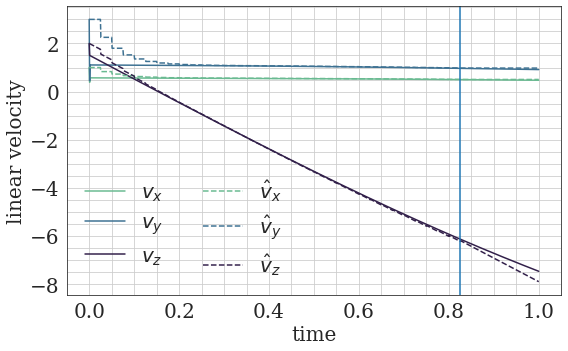

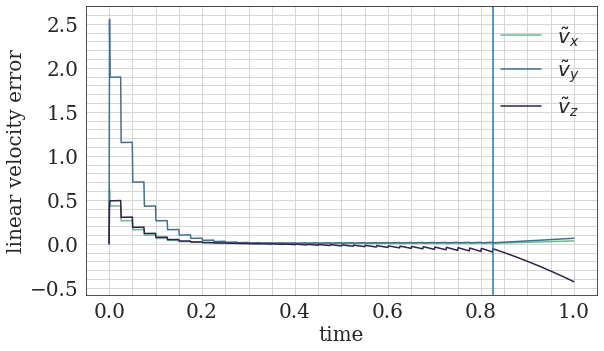

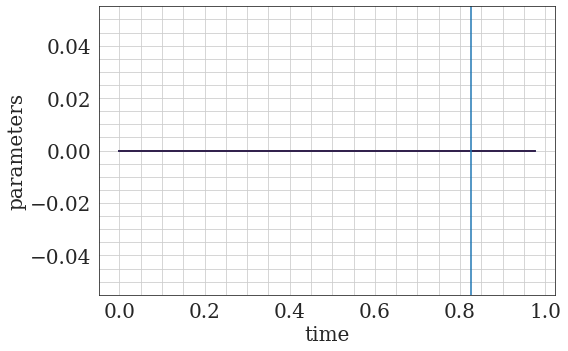

In [ ]:
### Visualize the results.
measurement_no = 33
make_prediction_comparison_plot(nsteps*nframes+1, dt, state_observations, predictor_states, measurement_no, 'linear velocity')
make_parameter_plot(nframes, nsteps, dt, params_over_time, measurement_no)

## Dynamics prediction with rotational dynamics

Here we consider performing dynamics prediction for a system with nontrivial rotational dynamics. PyBullet makes it a bit difficult to do this, and also has a different integration system than our predictor. To simplify the problem, and to avoid these integration differences, we implement the rotational dynamics ourselves.

We will implement the "ground truth" rotational dynamics in the world frame, meaning that we have to keep track of a changing moment of inertia tensor using the parallel axis theorem. We will then take observations from a rollout of this system. The predictor will implement the translational dynamics in the world frame and the rotational dynamics in the body frame.

In [ ]:
# moment of inertia matrix for an ellipse.
J_def = jnp.array([[5.0, 1.0, 0], 
                   [1.0, 2, 0], 
                   [0, 0, 0.5]])

# mass of the object
m_def = 1.0

# drag and magnus terms.
Cd = 0.5
Cl = 0.5

def rotational_dynamics_body(x, u, t, J=J_def):
  """ Implements rotational dynamics w.r.t the center of mass in the body frame."""
  q, p, v, w = x[:4], x[4:7], x[7:10], x[10:]
  qdot = .5 * vector_multiply(w, q)
  pdot = v
  R = to_rotation_matrix(q)
  w_world = R @ w
  vdot = grav - Cd*jnp.linalg.norm(v)*v + Cl*jnp.cross(w_world, v)
  wdot = -jnp.linalg.inv(J) @ jnp.cross(w, J @ w)
  
  return jnp.concatenate((qdot, pdot, vdot, wdot))
  
#disc_rot_dyn = jax.jit(rk4(rotational_dynamics, dt=dt))
disc_rot_dyn = jax.jit(rk4(rotational_dynamics_body, dt=dt))

In [ ]:
# initialize with nontrivial rotational dynamics.
q_init = jnp.array([0, 0, 0, 1])
p_init = jnp.array([0, 0, 10.0])
v_init = jnp.array([1.5, 0.0, 2.5])
w_init = jnp.array([3.0, 2.0, 1.0])
x_init = jnp.concatenate((q_init, p_init, v_init, w_init))

# construct the adaptive predictor
predictor = AdaptivePredictor(predictor_continuous, measurement_function, adapt_continuous, norm_state, 
                              x_init, init_params, n_features, dt, nsteps, nframes, potentials, 
                              potential_params, prediction_index=nframes)

# store the state of the predictor and the parameters over the entire trajectory.
predictor_states = []
params_over_time = onp.zeros((nframes, nparams))
params_over_time[0, :] = init_params

# store the pybullet state over time
state_observations = onp.zeros((1+nsteps*nframes, 13))
state_observations[0, :] = x_init

# rollout the simulation
state_observation = x_init
xt = x_init
for t in range(nsteps*nframes):
  xt = disc_rot_dyn(xt, 0, t)

  # incorporate the measurement and update the parameters
  new_measurement = (t % nsteps) == 0
  if new_measurement:
    ind = int(t / nsteps)
    predictor.update_state(state_observation)
    predictor_states.append(predictor.state_prediction.copy())
    params_over_time[ind, :] = predictor.params

  # save the state observations over time for direct comparison
  state_observation = xt
  state_observations[t+1, :] = xt

  print("Finished iteration %d" % t)

Finished iteration 0
Finished iteration 1
Finished iteration 2
Finished iteration 3
Finished iteration 4
Finished iteration 5
Finished iteration 6
Finished iteration 7
Finished iteration 8
Finished iteration 9
Finished iteration 10
Finished iteration 11
Finished iteration 12
Finished iteration 13
Finished iteration 14
Finished iteration 15
Finished iteration 16
Finished iteration 17
Finished iteration 18
Finished iteration 19
Finished iteration 20
Finished iteration 21
Finished iteration 22
Finished iteration 23
Finished iteration 24
Finished iteration 25
Finished iteration 26
Finished iteration 27
Finished iteration 28
Finished iteration 29
Finished iteration 30
Finished iteration 31
Finished iteration 32
Finished iteration 33
Finished iteration 34
Finished iteration 35
Finished iteration 36
Finished iteration 37
Finished iteration 38
Finished iteration 39
Finished iteration 40
Finished iteration 41
Finished iteration 42
Finished iteration 43
Finished iteration 44
Finished iteration 4

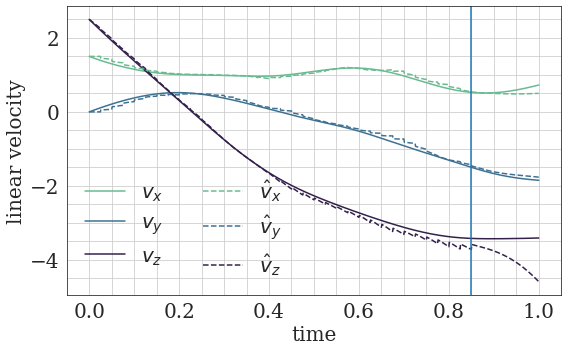

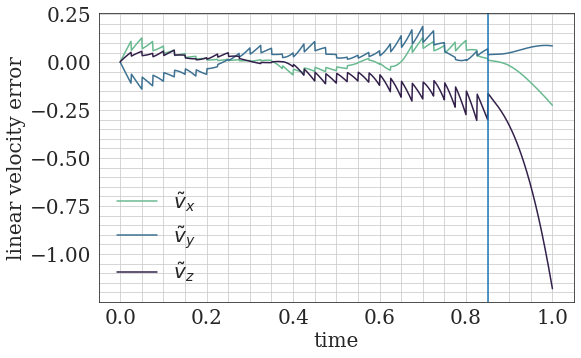

In [ ]:
### Visualize the results.
measurement_no = 34
make_prediction_comparison_plot(nsteps*nframes+1, dt, state_observations, predictor_states, measurement_no, 'linear velocity')

In [ ]:
make_parameter_plot(nframes, nsteps, dt, params_over_time, measurement_no)